In [10]:
import os
from PIL import Image
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from sklearn.metrics import precision_recall_curve
from tensorflow.keras.losses import binary_crossentropy

In [11]:
img_size = (128, 128)
img_size_chanels = (128,128,3)
epochs = 10
batch_size = 2

#### Loss

In [12]:
def dice_loss(y_true, y_pred):
    smooth = 1.0
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combine_bce_dice_losse(y_true, y_pred):image_path
    bce = tf.keras.losses.BinaryCrossentropy()
    alpha = 0.5
    loss = (alpha * bce(y_true, y_pred)) + ((1-alpha) * dice_loss(y_true, y_pred))
    return loss

#### data loader

In [ ]:
def load_images_and_masks(image_dir, mask_dir, image_size=img_size):
    images = []
    masks = []

    image_files = sorted(os.listdir(image_dir))  
    mask_files = sorted(os.listdir(mask_dir))    

    for image_file in image_files:
        if image_file.endswith('.jpg') or image_file.endswith('.jpeg') or image_file.endswith('.png'):
            image_path = os.path.join(image_dir, image_file)
            mask_file = image_file.split('.')[0] + '_mask.png' 

            if mask_file in mask_files:
                mask_path = os.path.join(mask_dir, mask_file)

               
                image = Image.open(image_path)
                image = image.resize(image_size)
                image = np.array(image) / 255.0

                
                mask = Image.open(mask_path).convert('L')
                mask = mask.resize(image_size, Image.NEAREST)
                mask = np.array(mask) / 255.0
                mask = np.expand_dims(mask, axis=-1)

                images.append(image)
                masks.append(mask)

    return np.array(images), np.array(masks)

In [14]:
image_dir = '/kaggle/input/data-and-label-of-kltn/image/image ver 2'
mask_dir = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label'
X, Y = load_images_and_masks(image_dir, mask_dir, image_size=img_size)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.05, random_state=42)

In [16]:
X_val, X_test, Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)

### build Unet

In [16]:
def unet_model(input_size=img_size_chanels):  
    inputs = Input(input_size)

    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = concatenate([up6, conv4], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(up6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = concatenate([up7, conv3], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(up7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = concatenate([up8, conv2], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(up8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = concatenate([up9, conv1], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(up9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    return model

model1 = unet_model(input_size=img_size_chanels)
model1.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 128, 128,  │      1,792 │ input_layer_1[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 128, 128,  │     36,928 │ conv2d_19[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 64, 64,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 64, 64,    │    147,584 │ conv2d_21[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 32, 32,    │          0 │ conv2d_22[0][0]   │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 32, 32,    │    295,168 │ max_pooling2d_5[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 32, 32,    │    590,080 │ conv2d_23[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 16, 16,    │          0 │ conv2d_24[0][0]   │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 16, 16,    │  1,180,160 │ max_pooling2d_6[… │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 16, 16,    │  2,359,808 │ conv2d_25[0][0]   │
│                     │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 8, 8, 512) │          0 │ conv2d_26[0][0]   │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 8, 8,      │  4,719,616 │ max_pooling2d_7[… │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 8, 8,      │  9,438,208 │ conv2d_27[0][0]   │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_4     │ (None, 16, 16,    │          0 │ conv2d_28[0][0]   │
│ (UpSampling2D)      │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, 16, 16,    │          0 │ up_sampling2d_4[

 Total params: 31,378,945 (119.70 MB)

 Trainable params: 31,378,945 (119.70 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history1 = model1.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=epochs,
                    batch_size=batch_size)

Epoch 1/10
   2/1930 ━━━━━━━━━━━━━━━━━━━━ 2:31 79ms/step - accuracy: 0.8914 - loss: 0.6014   

I0000 00:00:1721135005.671654     443 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1930/1930 ━━━━━━━━━━━━━━━━━━━━ 150s 61ms/step - accuracy: 0.9839 - loss: 0.3900 - val_accuracy: 0.9869 - val_loss: 0.0423
Epoch 2/10
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 98s 51ms/step - accuracy: 0.9899 - loss: 0.0309 - val_accuracy: 0.9907 - val_loss: 0.0285
Epoch 3/10
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 99s 51ms/step - accuracy: 0.9930 - loss: 0.0215 - val_accuracy: 0.9939 - val_loss: 0.0180
Epoch 4/10
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 98s 51ms/step - accuracy: 0.9937 - loss: 0.0194 - val_accuracy: 0.9944 - val_loss: 0.0164
Epoch 5/10
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 98s 51ms/step - accuracy: 0.9945 - loss: 0.0170 - val_accuracy: 0.9956 - val_loss: 0.0143
Epoch 6/10
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 98s 51ms/step - accuracy: 0.9949 - loss: 0.0155 - val_accuracy: 0.9958 - val_loss: 0.0133
Epoch 7/10
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 97s 50ms/step - accuracy: 0.9869 - loss: 0.0533 - val_accuracy: 0.9893 - val_loss: 0.0319
Epoch 8/10
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 142s 50ms/step - accuracy: 0.9886 - loss: 0.

## Evaluate Unet

In [21]:
def calculate_metrics(y_true, y_pred):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    true_positive = 0
    false_positive = 0
    false_negative = 0
    true_negative = 0
    for true, pred in zip(y_true, y_pred):
        if true == 1 and pred == 1:
            true_positive += 1
        elif true == 0 and pred == 1:
            false_positive += 1
        elif true == 1 and pred == 0:
            false_negative += 1
    accuracy = np.mean(y_true == y_pred)
    precision = true_positive / (true_positive + false_positive) if (true_positive + false_positive) > 0 else 0
    recall = true_positive / (true_positive + false_negative) if (true_positive + false_negative) > 0 else 0
    dice_score = (2 * true_positive) / (2 * true_positive + false_positive + false_negative) if (2 * true_positive + false_positive + false_negative) > 0 else 0
    iou = true_positive / (true_positive + false_positive + false_negative) if (true_positive + false_positive + false_negative) > 0 else 0
    return accuracy,precision,recall,dice_score, iou


In [19]:
y_true_val_model1 = Y_val
y_pred_probality_val_mode1 = model1.predict(X_val)
y_pred_val_model1 = np.where(y_pred_probality_val_mode1 > 0.5, 1, 0)
accuracy_val_model1, precision_val_model1, recall_val_model1, dice_score_val_model1, iou_val_model1 = calculate_metrics(y_true_val_model1, y_pred_val_model1)

print(f"Accuracy | Unet | validation data: {accuracy_val_model1}")
print(f"Precision | Unet | validation data: {precision_val_model1}")
print(f"Recall | Unet | validation data: {recall_val_model1}")
print(f"Dice Score | Unet | validation data: {dice_score_val_model1}")
print(f"IoU | Unet | validation data: {iou_val_model1}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 5s/step
Accuracy | Unet | validation data: 0.9922802495021447
Precision | Unet | validation data: 0.8382451572178167
Recall | Unet | validation data: 0.7071019701810437
Dice Score | Unet | validation data: 0.7671089448506183
IoU | Unet | validation data: 0.622203350122994


In [42]:
y_true_flat = y_true_val_model1.flatten()
y_pred_flat = y_pred_probality_val_mode1.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_true_flat, y_pred_flat)

Precision tại ngưỡng 0.5: 0.8382451572178167
Recall tại ngưỡng 0.5: 0.7071019701810437


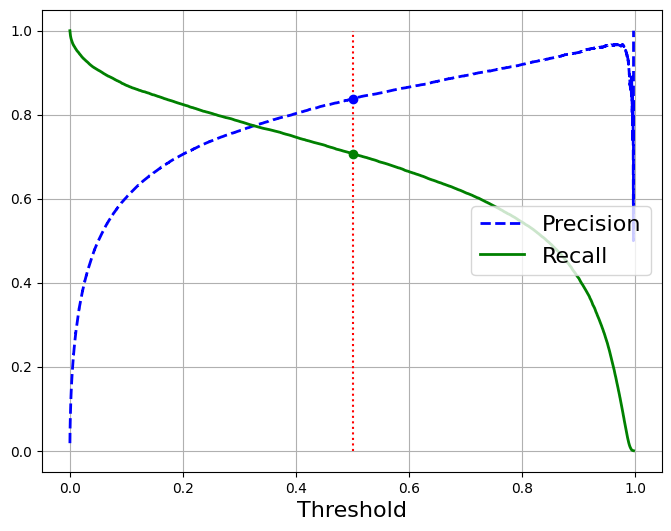

Precision tại ngưỡng 0.5: 0.8382451572178167
Recall tại ngưỡng 0.5: 0.7071019701810437


In [44]:
idx = np.argmax(thresholds >= 0.5)

precision_at_05_threshold = precisions[idx]
recall_at_05_threshold = recalls[idx]

print(f"Precision tại ngưỡng 0.5: {precision_at_05_threshold}")
print(f"Recall tại ngưỡng 0.5: {recall_at_05_threshold}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

plt.plot([0.5, 0.5], [0., 1.], "r:")
plt.plot([0.5], [precisions[idx]], "bo")
plt.plot([0.5], [recalls[idx]], "go")

plt.show()

print(f"Precision tại ngưỡng 0.5: {precisions[idx]}")
print(f"Recall tại ngưỡng 0.5: {recalls[idx]}")

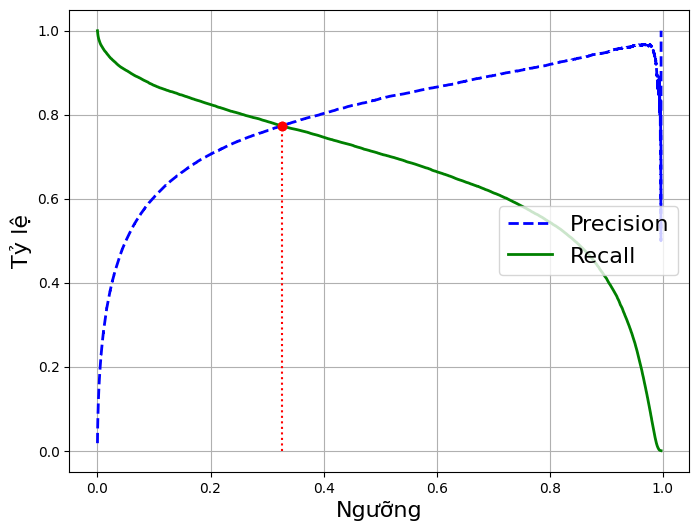

Ngưỡng threshold khi precision và recall giao nhau là: 0.3256620466709137
Precision tại ngưỡng này: 0.7736621405750799
Recall tại ngưỡng này: 0.7736621405750799


In [45]:
intersection_threshold = thresholds[np.argmin(abs(precisions - recalls))]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Ngưỡng", fontsize=16)
plt.ylabel("Tỷ lệ", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

plt.plot([intersection_threshold, intersection_threshold], [0., precisions[np.argmin(abs(precisions - recalls))]], "r:")
plt.plot([intersection_threshold], [precisions[np.argmin(abs(precisions - recalls))]], "ro")
plt.plot([intersection_threshold], [recalls[np.argmin(abs(precisions - recalls))]], "ro")

plt.show()

print(f"Ngưỡng threshold khi precision và recall giao nhau là: {intersection_threshold}")
print(f"Precision tại ngưỡng này: {precisions[np.argmin(abs(precisions - recalls))]}")
print(f"Recall tại ngưỡng này: {recalls[np.argmin(abs(precisions - recalls))]}")


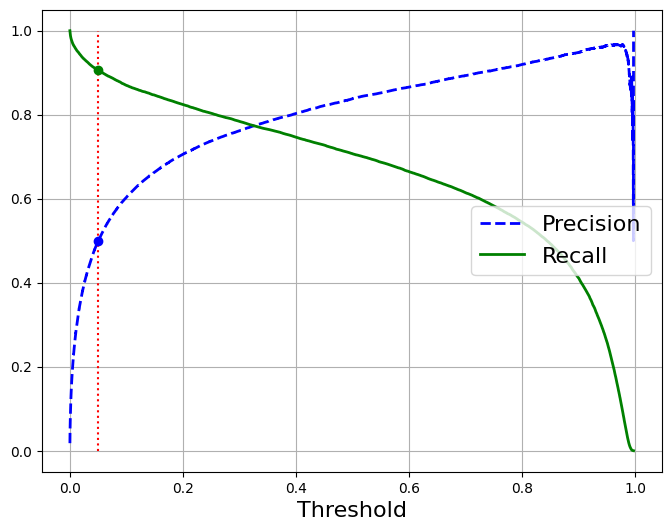

Ngưỡng threshold khi recall >= 90% là: 0.0503971204161644
Precision tại ngưỡng này: 0.5
Recall tại ngưỡng này: 0.9058839190628328


In [48]:
idx = np.where((recalls >= 0.9) & (precisions >= 0.50))[0][0]
threshold_90_recall_75_precision = thresholds[idx]


plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

plt.plot([threshold_90_recall_75_precision, threshold_90_recall_75_precision], [0., 1.], "r:")
plt.plot([threshold_90_recall_75_precision], [precisions[idx]], "bo")
plt.plot([threshold_90_recall_75_precision], [recalls[idx]], "go")

plt.show()

print(f"Ngưỡng threshold khi recall >= 90% là: {threshold_90_recall_75_precision}")
print(f"Precision tại ngưỡng này: {precisions[idx]}")
print(f"Recall tại ngưỡng này: {recalls[idx]}")


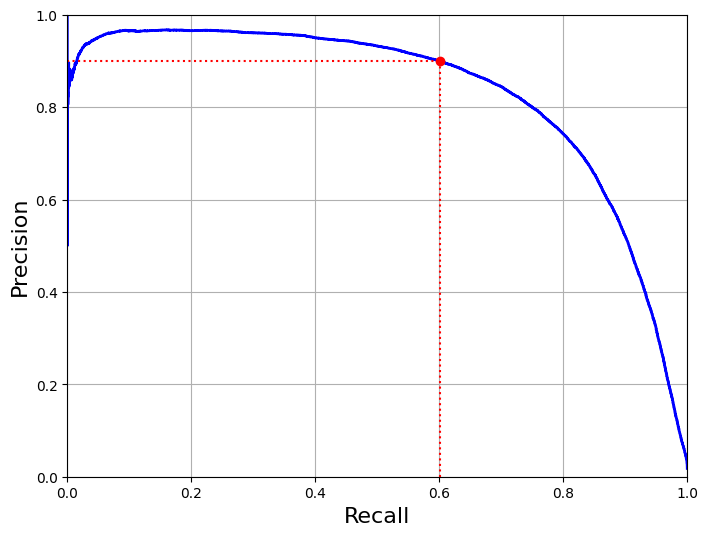

Recall tại mức Precision đạt 0.9 là: 0.6007055378061767


In [46]:
threshold_precision = 0.9
recall_90_precision = recalls[np.argmax(precisions >= threshold_precision)]
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., threshold_precision], "r:")
plt.plot([0.0, recall_90_precision], [threshold_precision, threshold_precision], "r:")
plt.plot([recall_90_precision], [threshold_precision], "ro")
plt.show()
print(f"Recall tại mức Precision đạt {threshold_precision} là: {recall_90_precision}")

In [39]:
#test result
y_true_test1_model1 = Y_test
y_pred_probality_test1_model1 = model1.predict(X_test)
y_pred_test1_model1 = np.where(y_pred_probality_test1_model1 > 0.5, 1, 0)
accuracy_test1, precision_test1, recall_test1, dice_score_test1, iou_test1 = calculate_metrics(y_true_test1_model1, y_pred_test1_model1)

print(f"Accuracy | Unet | test data: {accuracy_test1}")
print(f"Precision | Unet | test data: {precision_test1}")
print(f"Recall | Unet | test data: {recall_test1}")
print(f"Dice Score | Unet | test data: {dice_score_test1}")
print(f"IoU | Unet | test data: {iou_test1}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
Accuracy | Unet | test data: 0.9930132697610294
Precision | Unet | test data: 0.8415806336774653
Recall | Unet | test data: 0.7349984454347601
Dice Score | Unet | test data: 0.7846868776277938
IoU | Unet | test data: 0.6456664238892935


## Inference

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


(-0.5, 127.5, 127.5, -0.5)

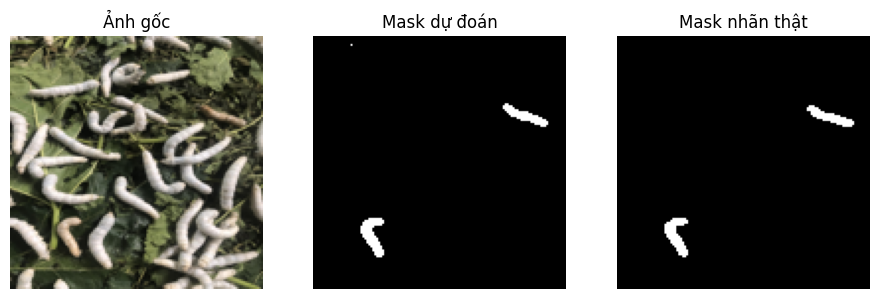

In [56]:

path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_450.jpg'
test_image_path = path  + image_path

test_image = Image.open(test_image_path)
test_image = test_image.resize((img_size))
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)


mask_path = mask_p + image_path.replace(".jpg","_mask.png")
mask_image = Image.open(mask_path)
mask_image = mask_image.resize(img_size,Image.NEAREST)
mask_image = np.array(mask_image) / 255.0



predicted_mask = model1.predict(test_image)
plt.figure(figsize=(15, 10))

threshold = 0.5

binary_mask = np.where(predicted_mask > threshold, 1, 0)


plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image[0])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image,cmap='gray')
plt.axis('off')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


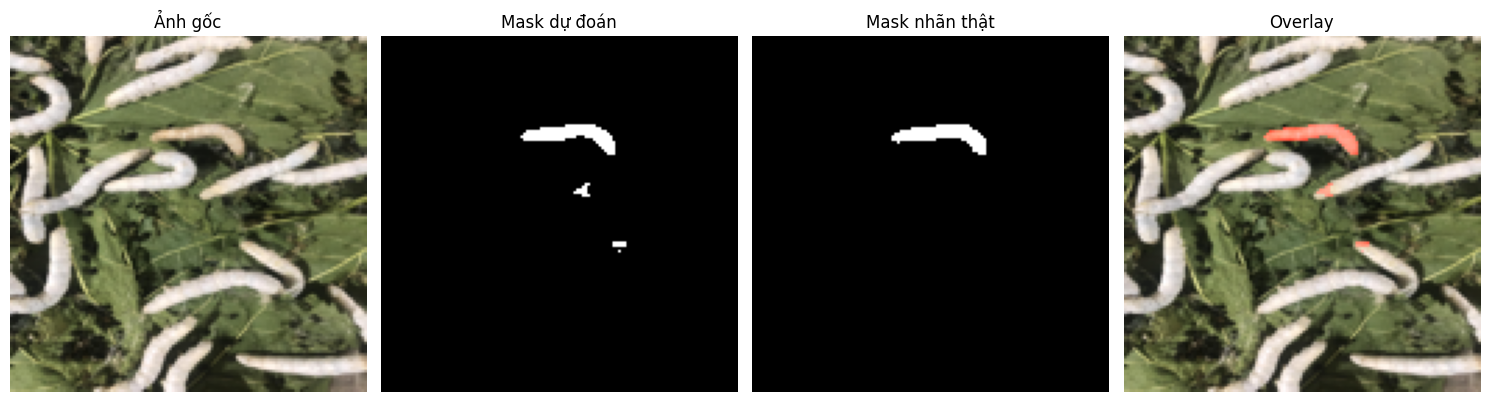

In [67]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_500.jpg'


test_image_path = os.path.join(path, image_path)
test_image = Image.open(test_image_path).convert('RGB')
test_image = test_image.resize(img_size)
test_image_np = np.array(test_image) / 255.0
test_image_np_copy = test_image_np.copy()  


mask_path = os.path.join(mask_p, image_path.replace(".jpg", "_mask.png"))
mask_image = Image.open(mask_path)
mask_image = mask_image.resize(img_size,Image.NEAREST)
mask_image_np = np.array(mask_image) / 255.0


predicted_mask = model1.predict(np.expand_dims(test_image_np_copy, axis=0))


threshold = 0.65
binary_mask = np.where(predicted_mask > threshold, 1, 0)


plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image)
plt.axis('off')


plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')


plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image, cmap='gray')
plt.axis('off')


overlay_image = test_image_np_copy  
overlay_mask = binary_mask[0, :, :, 0] 


red_mask = np.zeros_like(overlay_image)
red_mask[:,:,0] = 255  


overlay_mask = np.expand_dims(overlay_mask, axis=-1)
alpha = 0.2

overlay_image = np.where(overlay_mask == 1, (1 - alpha) * overlay_image + alpha * red_mask, overlay_image)

# Hiển thị ảnh overlay
plt.subplot(1, 4, 4)
plt.title("Overlay")
plt.imshow(overlay_image)
plt.axis('off')

plt.tight_layout()
plt.show()


#### Fine-tune Unet + VGG16

In [68]:
pip install segmentation_models
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
from tensorflow import keras
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from tensorflow.keras.optimizers import Adam


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Note: you may need to restart the kernel to use updated packages.


In [69]:

BACKBONE = 'vgg16'
preprocess_input = sm.get_preprocessing(BACKBONE)



model4 = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(128, 128, 3), classes=1, activation='sigmoid')


model4.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])


history4 = model4.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=20,
                    batch_size=2)

Segmentation Models: using `tf.keras` framework.
Epoch 1/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 106s 44ms/step - accuracy: 0.9560 - loss: 0.1998 - val_accuracy: 0.9902 - val_loss: 0.0317
Epoch 2/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.9946 - loss: 0.0189 - val_accuracy: 0.9931 - val_loss: 0.0210
Epoch 3/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - accuracy: 0.9955 - loss: 0.0137 - val_accuracy: 0.9957 - val_loss: 0.0139
Epoch 4/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - accuracy: 0.9959 - loss: 0.0118 - val_accuracy: 0.9959 - val_loss: 0.0128
Epoch 5/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 71s 37ms/step - accuracy: 0.9962 - loss: 0.0105 - val_accuracy: 0.9953 - val_loss: 0.0138
Epoch 6/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 72s 37ms/step - accuracy: 0.9966 - loss: 0.0093 - val_accuracy: 0.9946 - val_loss: 0.0158
Epoch 7/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 73s 38ms/step - accuracy: 0.9968 - loss: 0.0087 - val_accuracy: 0.9957 - val_loss: 0.0134
Epoch 8/20
1930/1930 ━━━━━

#### evaluate and analyis Unet+VGG16

In [70]:
y_true_val_model4 = Y_val
y_pred_probality_val_model4 = model4.predict(X_val)
y_pred_val_model4 = np.where(y_pred_probality_val_model4 > 0.5, 1, 0)
accuracy_val_model4, precision_val_model4, recall_val_model4, dice_score_val_model4, iou_val_model4 = calculate_metrics(y_true_val_model4, y_pred_val_model4)

print(f"Accuracy | Unet+VGG16 | validation data: {accuracy_val_model4}")
print(f"Precision | Unet+VGG16 | validation data: {precision_val_model4}")
print(f"Recall | Unet+VGG16 | validation data: {recall_val_model4}")
print(f"Dice Score | Unet+VGG16 | validation data: {dice_score_val_model4}")
print(f"IoU | Unet+VGG16 | validation data: {iou_val_model4}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 15s 2s/step
Accuracy | Unet+VGG16 | validation data: 0.9955911075367647
Precision | Unet+VGG16 | validation data: 0.9074739489759253
Recall | Unet+VGG16 | validation data: 0.8404885516506923
Dice Score | Unet+VGG16 | validation data: 0.872697743529493
IoU | Unet+VGG16 | validation data: 0.7741470741501395


In [72]:
y_true_flat = y_true_val_model4.flatten()
y_pred_flat = y_pred_probality_val_model4.flatten()

# Tính precision và recall từ các dự đoán
precisions, recalls, thresholds = precision_recall_curve(y_true_flat, y_pred_flat)

Precision tại ngưỡng 0.5: 0.9074739489759253
Recall tại ngưỡng 0.5: 0.8404885516506923


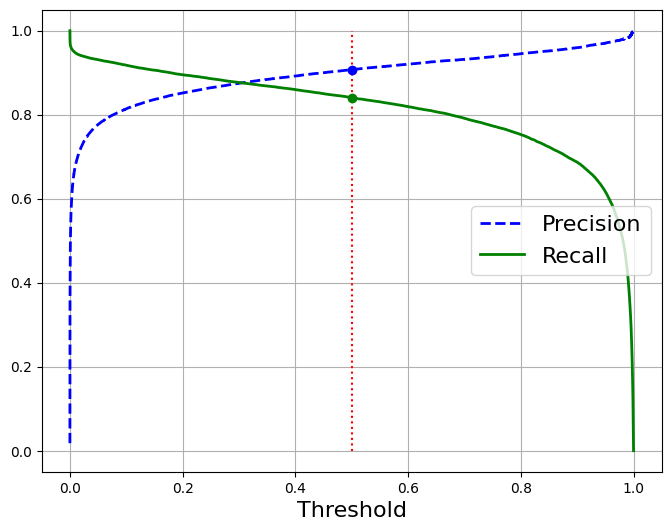

Precision tại ngưỡng 0.5: 0.9074739489759253
Recall tại ngưỡng 0.5: 0.8404885516506923


In [73]:
idx = np.argmax(thresholds >= 0.5)

# Lấy giá trị precision và recall tại ngưỡng 0.5
precision_at_05_threshold = precisions[idx]
recall_at_05_threshold = recalls[idx]

print(f"Precision tại ngưỡng 0.5: {precision_at_05_threshold}")
print(f"Recall tại ngưỡng 0.5: {recall_at_05_threshold}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

# Vẽ điểm và đường chỉ ra ngưỡng 0.5
plt.plot([0.5, 0.5], [0., 1.], "r:")
plt.plot([0.5], [precisions[idx]], "bo")
plt.plot([0.5], [recalls[idx]], "go")

plt.show()

# In ra giá trị precision và recall tại ngưỡng 0.5
print(f"Precision tại ngưỡng 0.5: {precisions[idx]}")
print(f"Recall tại ngưỡng 0.5: {recalls[idx]}")

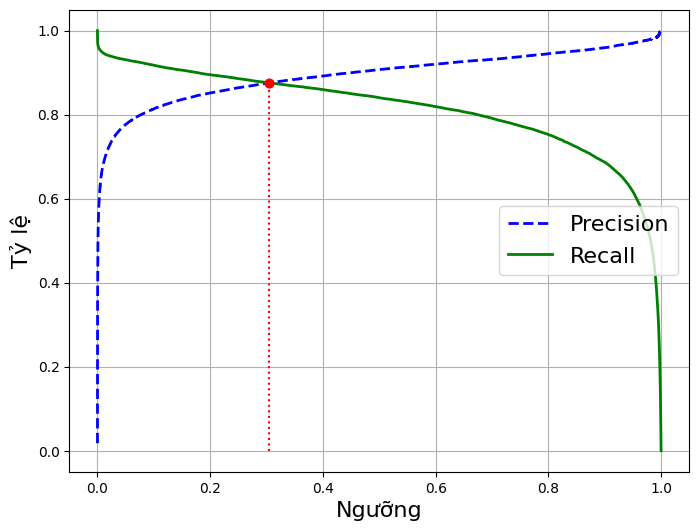

Ngưỡng threshold khi precision và recall giao nhau là: 0.30496010184288025
Precision tại ngưỡng này: 0.8758320021299254
Recall tại ngưỡng này: 0.8758320021299254


In [74]:
intersection_threshold = thresholds[np.argmin(abs(precisions - recalls))]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Ngưỡng", fontsize=16)
plt.ylabel("Tỷ lệ", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

plt.plot([intersection_threshold, intersection_threshold], [0., precisions[np.argmin(abs(precisions - recalls))]], "r:")
plt.plot([intersection_threshold], [precisions[np.argmin(abs(precisions - recalls))]], "ro")
plt.plot([intersection_threshold], [recalls[np.argmin(abs(precisions - recalls))]], "ro")

plt.show()

print(f"Ngưỡng threshold khi precision và recall giao nhau là: {intersection_threshold}")
print(f"Precision tại ngưỡng này: {precisions[np.argmin(abs(precisions - recalls))]}")
print(f"Recall tại ngưỡng này: {recalls[np.argmin(abs(precisions - recalls))]}")


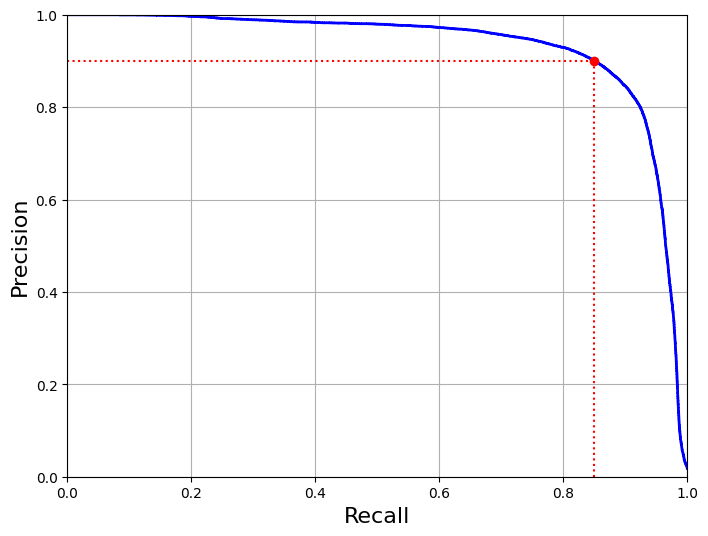

Recall tại mức Precision đạt 0.9 là: 0.8502396166134185


In [75]:
threshold_precision = 0.9
recall_90_precision = recalls[np.argmax(precisions >= threshold_precision)]
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., threshold_precision], "r:")
plt.plot([0.0, recall_90_precision], [threshold_precision, threshold_precision], "r:")
plt.plot([recall_90_precision], [threshold_precision], "ro")
plt.show()
print(f"Recall tại mức Precision đạt {threshold_precision} là: {recall_90_precision}")

## 4.3 Test result of Unet+VGG16

In [76]:
y_true_test1_model4 = Y_test
y_pred_probality_test1_model4 = model4.predict(X_test)
y_pred_test1_model4 = np.where(y_pred_probality_test1_model4 > 0.5, 1, 0)
accuracy_test1_model4, precision_test1_model4, recall_test1_model4, dice_score_test1_model4, iou_test1_model4 = calculate_metrics(y_true_test1_model4, y_pred_test1_model4)

print(f"Accuracy | Unet+VGG16 | test data: {accuracy_test1_model4}")
print(f"Precision | Unet+VGG16 | test data: {precision_test1_model4}")
print(f"Recall | Unet+VGG16 | test data: {recall_test1_model4}")
print(f"Dice Score | Unet+VGG16 | test data: {dice_score_test1_model4}")
print(f"IoU | Unet+VGG16 | test data: {iou_test1_model4}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Accuracy | Unet+VGG16 | test data: 0.9958053289675245
Precision | Unet+VGG16 | test data: 0.9162144727355519
Recall | Unet+VGG16 | test data: 0.8341106159532939
Dice Score | Unet+VGG16 | test data: 0.873236889692586
IoU | Unet+VGG16 | test data: 0.7749959878029209


## 4.4 Demo predict Unet+VGG16

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 930ms/step


(-0.5, 127.5, 127.5, -0.5)

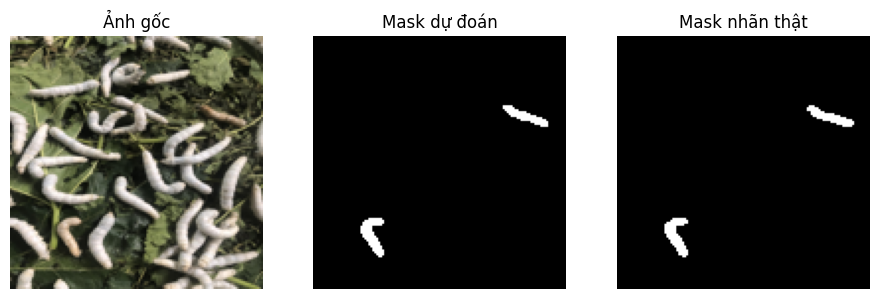

In [77]:
path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_450.jpg'
test_image_path = path  + image_path

test_image = Image.open(test_image_path)
test_image = test_image.resize((img_size))
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)

mask_path = mask_p + image_path.replace(".jpg","_mask.png")
mask_image = Image.open(mask_path)
mask_image = mask_image.resize(img_size,Image.NEAREST)
mask_image = np.array(mask_image) / 255.0


predicted_mask = model4.predict(test_image)
plt.figure(figsize=(15, 10))
threshold = 0.5
binary_mask = np.where(predicted_mask > threshold, 1, 0)

plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image[0])
plt.axis('off')
plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image,cmap='gray')
plt.axis('off')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


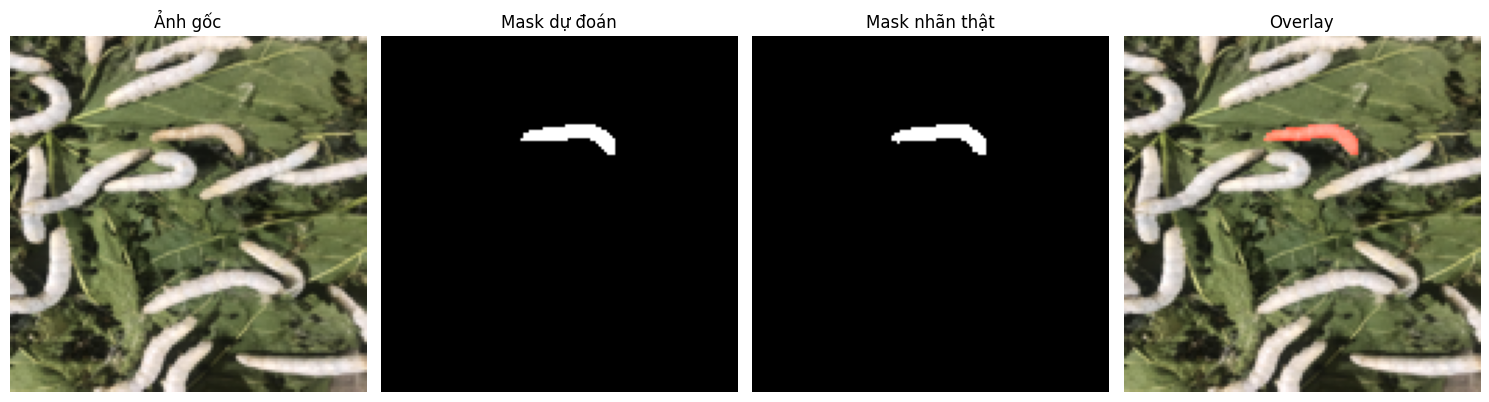

In [78]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_500.jpg'


test_image_path = os.path.join(path, image_path)
test_image = Image.open(test_image_path).convert('RGB')
test_image = test_image.resize(img_size)
test_image_np = np.array(test_image) / 255.0
test_image_np_copy = test_image_np.copy()  # Tạo bản sao của ảnh gốc để không thay đổi ảnh gốc


mask_path = os.path.join(mask_p, image_path.replace(".jpg", "_mask.png"))
mask_image = Image.open(mask_path)
mask_image = mask_image.resize(img_size,Image.NEAREST)
mask_image_np = np.array(mask_image) / 255.0


predicted_mask = model4.predict(np.expand_dims(test_image_np_copy, axis=0))


threshold = 0.5
binary_mask = np.where(predicted_mask > threshold, 1, 0)


plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image)
plt.axis('off')


plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')


plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image, cmap='gray')
plt.axis('off')

overlay_image = test_image_np_copy  
overlay_mask = binary_mask[0, :, :, 0] 


red_mask = np.zeros_like(overlay_image)
red_mask[:,:,0] = 255 


overlay_mask = np.expand_dims(overlay_mask, axis=-1)
alpha = 0.2

overlay_image = np.where(overlay_mask == 1, (1 - alpha) * overlay_image + alpha * red_mask, overlay_image)


plt.subplot(1, 4, 4)
plt.title("Overlay")
plt.imshow(overlay_image)
plt.axis('off')

plt.tight_layout()
plt.show()


#### build Unet + ResNet34

In [18]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import numpy as np
from tensorflow import keras
import segmentation_models as sm
from segmentation_models.metrics import iou_score
from tensorflow.keras.optimizers import Adam

Segmentation Models: using `tf.keras` framework.


In [24]:

BACKBONE = 'resnet34'
preprocess_input = sm.get_preprocessing(BACKBONE)




model3 = sm.Unet(BACKBONE, encoder_weights='imagenet', input_shape=(128, 128, 3), classes=1, activation='sigmoid')


model3.compile(optimizer='adam', loss=sm.losses.bce_dice_loss,metrics=['accuracy'])

history3 = model3.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=20,
                    batch_size=2)

Epoch 1/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 126s 44ms/step - accuracy: 0.9815 - loss: 0.4251 - val_accuracy: 0.9887 - val_loss: 0.5900
Epoch 2/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9945 - loss: 0.1959 - val_accuracy: 0.9762 - val_loss: 0.6098
Epoch 3/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9953 - loss: 0.1703 - val_accuracy: 0.9950 - val_loss: 0.1904
Epoch 4/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9954 - loss: 0.1640 - val_accuracy: 0.9955 - val_loss: 0.1682
Epoch 5/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9957 - loss: 0.1491 - val_accuracy: 0.9917 - val_loss: 0.3819
Epoch 6/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9959 - loss: 0.1430 - val_accuracy: 0.9949 - val_loss: 0.1863
Epoch 7/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9956 - loss: 0.1549 - val_accuracy: 0.9935 - val_loss: 0.2542
Epoch 8/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 66s 34ms/step - accuracy: 0.9960 

#### evaluate Unet+Resnet34

In [25]:
y_true_val_model3 = Y_val
y_pred_probality_val_model3 = model3.predict(X_val)
y_pred_val_model3 = np.where(y_pred_probality_val_model3 > 0.5, 1, 0)
accuracy_val_model3, precision_val_model3, recall_val_model3, dice_score_val_model3, iou_val_model3 = calculate_metrics(y_true_val_model3, y_pred_val_model3)

print(f"Accuracy | Unet+Resnet34| validation data: {accuracy_val_model3}")
print(f"Precision | UnetResnet34 | validation data: {precision_val_model3}")
print(f"Recall | Unet+Resnet34 | validation data: {recall_val_model3}")
print(f"Dice Score | Unet+Resnet34 | validation data: {dice_score_val_model3}")
print(f"IoU | Unet+Resnet34 | validation data: {iou_val_model3}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step 
Accuracy | Unet+Resnet34| validation data: 0.9959758683746937
Precision | UnetResnet34 | validation data: 0.9292208031212044
Recall | Unet+Resnet34 | validation data: 0.840189030883919
Dice Score | Unet+Resnet34 | validation data: 0.8824650016603457
IoU | Unet+Resnet34 | validation data: 0.7896531231428482


In [27]:
y_true_flat = y_true_val_model3.flatten()
y_pred_flat = y_pred_probality_val_model3.flatten()

precisions, recalls, thresholds = precision_recall_curve(y_true_flat, y_pred_flat)

Precision tại ngưỡng 0.5: 0.8999143957768583
Recall tại ngưỡng 0.5: 0.8396565495207667


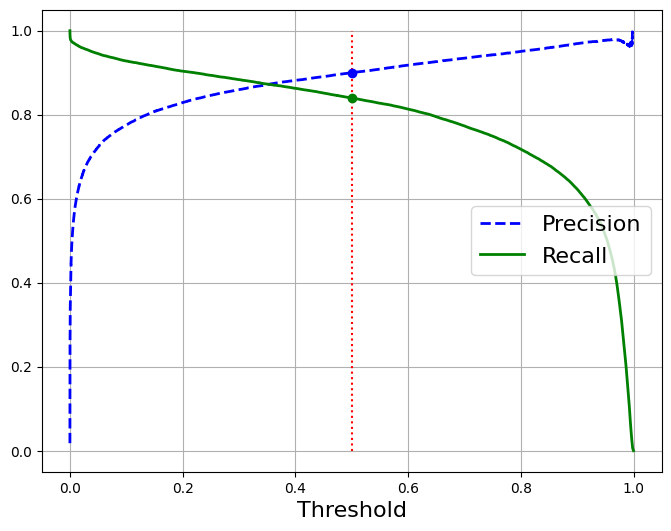

Precision tại ngưỡng 0.5: 0.8999143957768583
Recall tại ngưỡng 0.5: 0.8396565495207667


In [28]:
idx = np.argmax(thresholds >= 0.5)

precision_at_05_threshold = precisions[idx]
recall_at_05_threshold = recalls[idx]

print(f"Precision tại ngưỡng 0.5: {precision_at_05_threshold}")
print(f"Recall tại ngưỡng 0.5: {recall_at_05_threshold}")

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

plt.plot([0.5, 0.5], [0., 1.], "r:")
plt.plot([0.5], [precisions[idx]], "bo")
plt.plot([0.5], [recalls[idx]], "go")

plt.show()

print(f"Precision tại ngưỡng 0.5: {precisions[idx]}")
print(f"Recall tại ngưỡng 0.5: {recalls[idx]}")

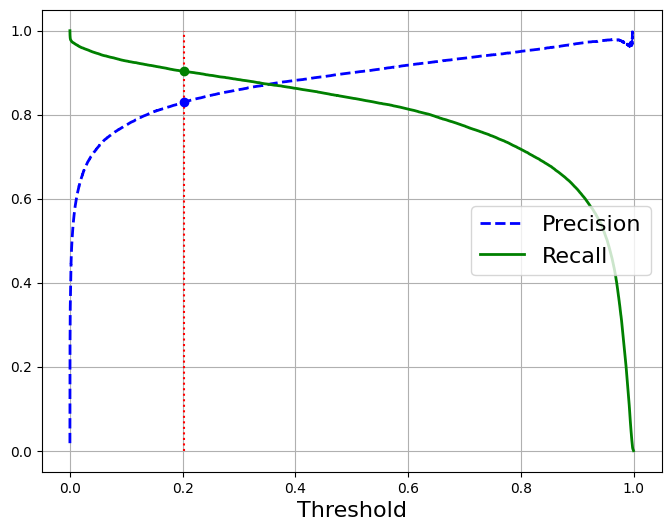

Ngưỡng threshold khi recall >= 90% và precision >= 80% là: 0.20273765921592712
Precision tại ngưỡng này: 0.8300155948995505
Recall tại ngưỡng này: 0.9033546325878594


In [34]:
idx = np.where((recalls >= 0.9) & (precisions >= 0.83))[0][0]
threshold_90_recall_75_precision = thresholds[idx]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Threshold", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

plt.plot([threshold_90_recall_75_precision, threshold_90_recall_75_precision], [0., 1.], "r:")
plt.plot([threshold_90_recall_75_precision], [precisions[idx]], "bo")
plt.plot([threshold_90_recall_75_precision], [recalls[idx]], "go")

plt.show()

print(f"Ngưỡng threshold khi recall >= 90% và precision >= 80% là: {threshold_90_recall_75_precision}")
print(f"Precision tại ngưỡng này: {precisions[idx]}")
print(f"Recall tại ngưỡng này: {recalls[idx]}")


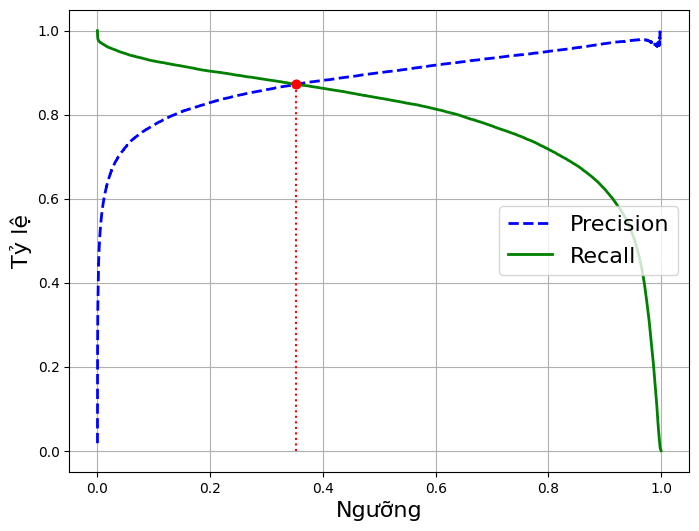

Ngưỡng threshold khi precision và recall giao nhau là: 0.3528306484222412
Precision tại ngưỡng này: 0.8724041533546326
Recall tại ngưỡng này: 0.8724041533546326


In [35]:
intersection_threshold = thresholds[np.argmin(abs(precisions - recalls))]

plt.figure(figsize=(8, 6))
plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.xlabel("Ngưỡng", fontsize=16)
plt.ylabel("Tỷ lệ", fontsize=16)
plt.legend(loc="center right", fontsize=16)
plt.grid(True)

plt.plot([intersection_threshold, intersection_threshold], [0., precisions[np.argmin(abs(precisions - recalls))]], "r:")
plt.plot([intersection_threshold], [precisions[np.argmin(abs(precisions - recalls))]], "ro")
plt.plot([intersection_threshold], [recalls[np.argmin(abs(precisions - recalls))]], "ro")

plt.show()

print(f"Ngưỡng threshold khi precision và recall giao nhau là: {intersection_threshold}")
print(f"Precision tại ngưỡng này: {precisions[np.argmin(abs(precisions - recalls))]}")
print(f"Recall tại ngưỡng này: {recalls[np.argmin(abs(precisions - recalls))]}")


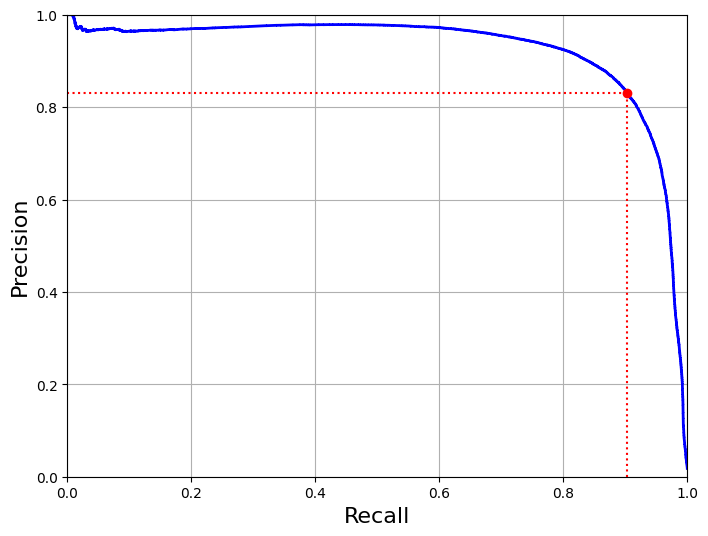

Recall tại mức Precision đạt 0.8300155948995505 là: 0.9033546325878594


In [37]:
threshold_precision = 0.8300155948995505
recall_90_precision = recalls[np.argmax(precisions >= threshold_precision)]
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., threshold_precision], "r:")
plt.plot([0.0, recall_90_precision], [threshold_precision, threshold_precision], "r:")
plt.plot([recall_90_precision], [threshold_precision], "ro")
plt.show()
print(f"Recall tại mức Precision đạt {threshold_precision} là: {recall_90_precision}")

#### test result of Unet+Resnet34

In [3]:
print(f"Ngưỡng threshold khi recall >= 90% và là: {threshold_90_recall_75_precision}")
print(f"Precision tại ngưỡng này: {precisions[idx]}")
print(f"Recall tại ngưỡng này: {recalls[idx]}

Ngưỡng quyết định khi recall >= 90% là: 0.35
Precision tại ngưỡng này: 0.8700155948995505
Recall tại ngưỡng này: 0.9033546325878594 


In [26]:
y_true_test1_model3 = Y_test
y_pred_probality_test1_model3 = model3.predict(X_test)
y_pred_test1_model3 = np.where(y_pred_probality_test1_model3 > 0.5, 1, 0)
accuracy_test1_model3, precision_test1_model3, recall_test1_model3, dice_score_test1_model3, iou_test1_model3 = calculate_metrics(y_true_test1_model3, y_pred_test1_model3)

print(f"Accuracy | Unet+Resnet34 | test data: {accuracy_test1_model3}")
print(f"Precision | Unet+Resnet34 | test data: {precision_test1_model3}")
print(f"Recall | Unet+Resnet34 | test data: {recall_test1_model3}")
print(f"Dice Score | Unet+Resnet34 | test data: {dice_score_test1_model3}")
print(f"IoU | Unet+Resnet34 | test data: {iou_test1_model3}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
Accuracy | Unet+Resnet34 | test data: 0.9958166982613358
Precision | Unet+Resnet34 | test data: 0.9204841427914815
Recall | Unet+Resnet34 | test data: 0.8302069299063807
Dice Score | Unet+Resnet34 | test data: 0.8730178911997094
IoU | Unet+Resnet34 | test data: 0.7746510653386197


#### Inference Unet+Resnet34

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(-0.5, 127.5, 127.5, -0.5)

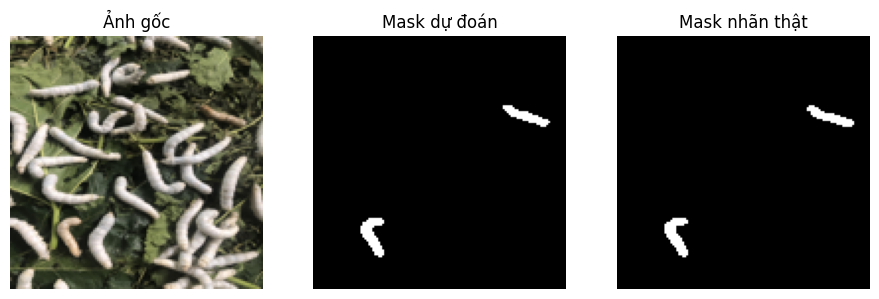

In [39]:

path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_450.jpg'
test_image_path = path  + image_path

test_image = Image.open(test_image_path)
test_image = test_image.resize((img_size))
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)


mask_path = mask_p + image_path.replace(".jpg","_mask.png")
mask_image = Image.open(mask_path)
mask_image = mask_image.resize(img_size,Image.NEAREST)
mask_image = np.array(mask_image) / 255.0



predicted_mask = model3.predict(test_image)
plt.figure(figsize=(15, 10))

threshold = 0.5

binary_mask = np.where(predicted_mask > threshold, 1, 0)


plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image[0])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image,cmap='gray')
plt.axis('off')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


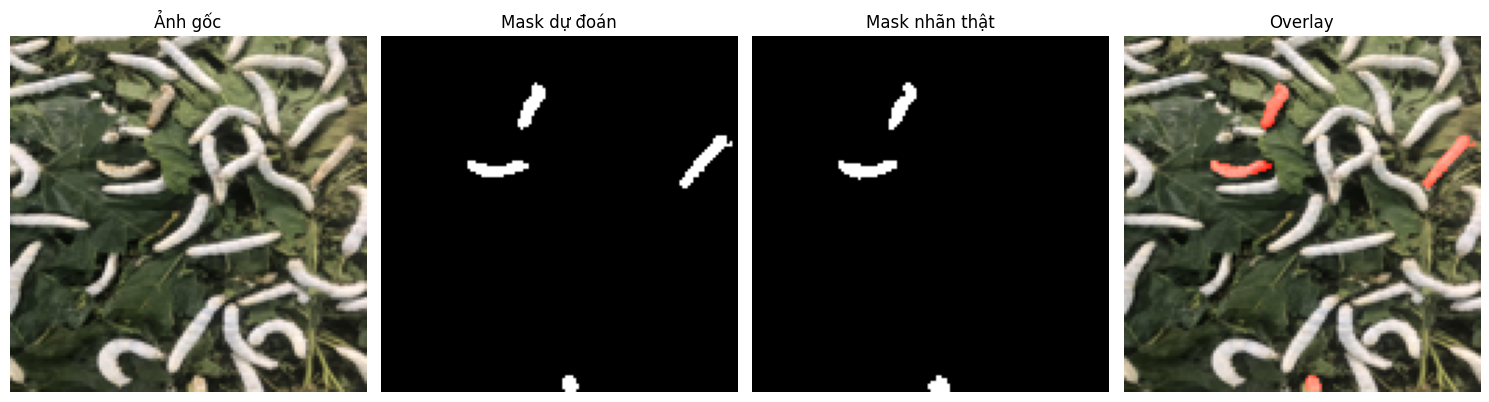

In [41]:

path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_460.jpg'


test_image_path = os.path.join(path, image_path)
test_image = Image.open(test_image_path).convert('RGB')
test_image = test_image.resize(img_size)
test_image_np = np.array(test_image) / 255.0
test_image_np_copy = test_image_np.copy() 


mask_path = os.path.join(mask_p, image_path.replace(".jpg", "_mask.png"))
mask_image = Image.open(mask_path)
mask_image = mask_image.resize(img_size,Image.NEAREST)
mask_image_np = np.array(mask_image) / 255.0


predicted_mask = model3.predict(np.expand_dims(test_image_np_copy, axis=0))


threshold = 0.5
binary_mask = np.where(predicted_mask > threshold, 1, 0)


plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image)
plt.axis('off')


plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')


plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image, cmap='gray')
plt.axis('off')


overlay_image = test_image_np_copy 
overlay_mask = binary_mask[0, :, :, 0]  


red_mask = np.zeros_like(overlay_image)
red_mask[:,:,0] = 255 


overlay_mask = np.expand_dims(overlay_mask, axis=-1)
alpha = 0.2
4
overlay_image = np.where(overlay_mask == 1, (1 - alpha) * overlay_image + alpha * red_mask, overlay_image)

# Hiển thị ảnh overlay
plt.subplot(1, 4, 4)
plt.title("Overlay")
plt.imshow(overlay_image)
plt.axis('off')

plt.tight_layout()
plt.show()


#### PSPNet 

In [47]:
BACKBONE = 'resnet34'
model6 = sm.PSPNet(BACKBONE, encoder_weights='imagenet', input_shape=(128, 128, 3), classes=1, activation='sigmoid')


model6.compile(optimizer='adam', loss=sm.losses.bce_dice_loss, metrics=[iou_score])


history6 = model6.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=20,
                    batch_size=2)


Epoch 1/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 61s 18ms/step - iou_score: 0.4523 - loss: 0.4595 - val_iou_score: 0.4274 - val_loss: 0.4988
Epoch 2/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - iou_score: 0.6192 - loss: 0.2783 - val_iou_score: 0.5636 - val_loss: 0.3424
Epoch 3/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - iou_score: 0.6494 - loss: 0.2552 - val_iou_score: 0.5312 - val_loss: 0.3866
Epoch 4/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - iou_score: 0.6733 - loss: 0.2353 - val_iou_score: 0.5341 - val_loss: 0.3802
Epoch 5/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - iou_score: 0.6859 - loss: 0.2256 - val_iou_score: 0.5962 - val_loss: 0.3137
Epoch 6/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - iou_score: 0.6907 - loss: 0.2213 - val_iou_score: 0.6182 - val_loss: 0.2909
Epoch 7/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - iou_score: 0.7033 - loss: 0.2102 - val_iou_score: 0.5940 - val_loss: 0.3225
Epoch 8/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - iou_

#### evaluate PSPNet

In [15]:
y_true_val_model6 = Y_val
y_pred_probality_val_model6 = model6.predict(X_val)
y_pred_val_model6 = np.where(y_pred_probality_val_model6 > 0.5, 1, 0)
accuracy_val_model6, precision_val_model6, recall_val_model6, dice_score_val_model6, iou_val_model6 = calculate_metrics(y_true_val_model6, y_pred_val_model6)

print(f"Accuracy | PSPNet | validation data: {accuracy_val_model6}")
print(f"Precision | PSPNet | validation data: {precision_val_model6}")
print(f"Recall | PSPNet | validation data: {recall_val_model6}")
print(f"Dice Score | PSPNet | validation data: {dice_score_val_model6}")
print(f"IoU | PSPNet | validation data: {iou_val_model6}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 317ms/step
Accuracy | PSPNet | validation data: 0.9939775099854756
Precision | PSPNet  | validation data: 0.8519621186344561
Recall | PSPNet | validation data: 0.7998881908209988
Dice Score | PSPNet | validation data: 0.8251043497363796
IoU | PSPNet | validation data: 0.7022788360406684


#### Test result of PSPNet+ResNet34

In [18]:
y_true_test1_model6 = Y_test
y_pred_probality_test1_model6 = model6.predict(X_test)
y_pred_test1_model6 = np.where(y_pred_probality_test1_model6 > 0.5, 1, 0)
accuracy_test6, precision_test6, recall_test6, dice_score_test6, iou_test6 = calculate_metrics(y_true_test1_model6, y_pred_test1_model6)

print(f"Accuracy | Unet | test data: {accuracy_test6}")
print(f"Precision | Unet | test data: {precision_test6}")
print(f"Recall | Unet | test data: {recall_test6}")
print(f"Dice Score | Unet | test data: {dice_score_test6}")
print(f"IoU | Unet | test data: {iou_test6}")
# -> print quên không sửa tên model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
Accuracy | PSPNet | test data:  0.9939775099854756
Precision | PSPNet | test data:  0.8519621186344561
Recall | PSPNet | test data: 0.7998881908209988
Dice Score | PSPNet | test data: 0.8251043497363796
IoU | PSPNet | test data: 0.7022788360406684


#### inference PSPNet+ResNet34

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


(-0.5, 143.5, 143.5, -0.5)

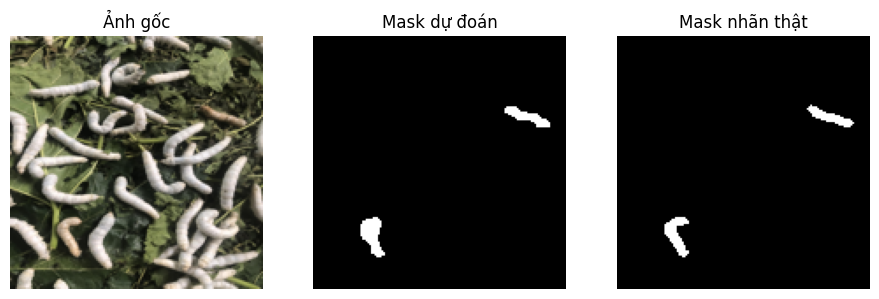

In [52]:

path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_450.jpg'
test_image_path = path  + image_path

test_image = Image.open(test_image_path)
test_image = test_image.resize((144,144))
test_image = np.array(test_image) / 255.0
test_image = np.expand_dims(test_image, axis=0)


mask_path = mask_p + image_path.replace(".jpg","_mask.png")
mask_image = Image.open(mask_path)
mask_image = mask_image.resize((144,144),Image.NEAREST)
mask_image = np.array(mask_image) / 255.0



predicted_mask = model6.predict(test_image)
plt.figure(figsize=(15, 10))

threshold = 0.5

binary_mask = np.where(predicted_mask > threshold, 1, 0)


plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image[0])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')

plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image,cmap='gray')
plt.axis('off')


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


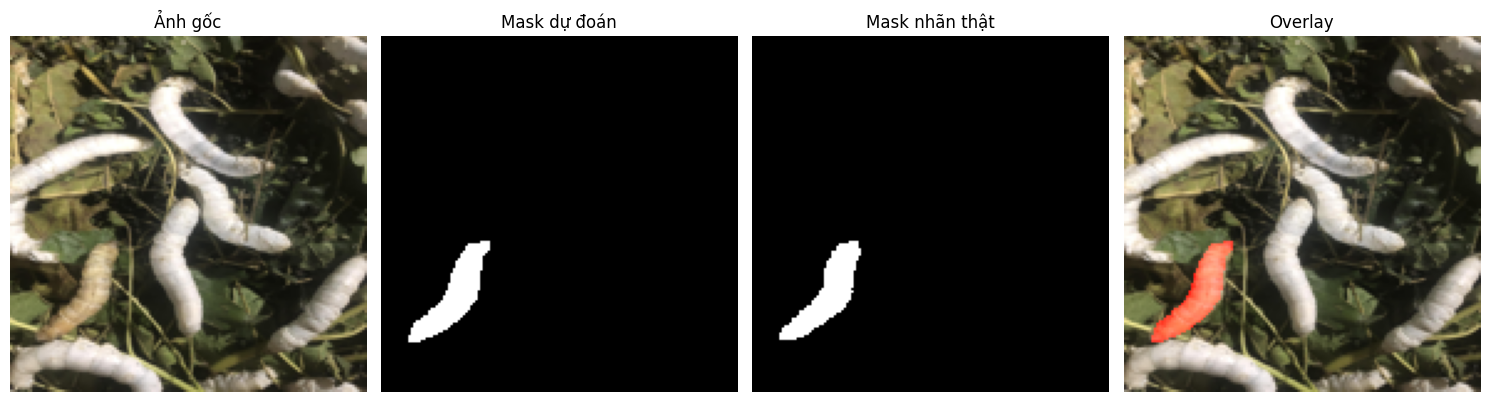

In [54]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt


path = '/kaggle/input/data-and-label-of-kltn/image/image ver 2/'
mask_p = '/kaggle/input/data-and-label-of-kltn/mask/image_mask_label/'
image_path = 'image_26.jpg'


test_image_path = os.path.join(path, image_path)
test_image = Image.open(test_image_path).convert('RGB')
test_image = test_image.resize((144,144))
test_image_np = np.array(test_image) / 255.0
test_image_np_copy = test_image_np.copy()  # Tạo bản sao của ảnh gốc để không thay đổi ảnh gốc


mask_path = os.path.join(mask_p, image_path.replace(".jpg", "_mask.png"))
mask_image = Image.open(mask_path)
mask_image = mask_image.resize((144,144),Image.NEAREST)
mask_image_np = np.array(mask_image) / 255.0


predicted_mask = model6.predict(np.expand_dims(test_image_np_copy, axis=0))


threshold = 0.65
binary_mask = np.where(predicted_mask > threshold, 1, 0)


plt.figure(figsize=(15, 10))
plt.subplot(1, 4, 1)
plt.title("Ảnh gốc")
plt.imshow(test_image)
plt.axis('off')


plt.subplot(1, 4, 2)
plt.title("Mask dự đoán")
plt.imshow(binary_mask[0, :, :, 0], cmap='gray')
plt.axis('off')


plt.subplot(1, 4, 3)
plt.title("Mask nhãn thật")
plt.imshow(mask_image, cmap='gray')
plt.axis('off')


overlay_image = test_image_np_copy  
overlay_mask = binary_mask[0, :, :, 0]  


red_mask = np.zeros_like(overlay_image)
red_mask[:,:,0] = 255  

overlay_mask = np.expand_dims(overlay_mask, axis=-1)
alpha = 0.2

overlay_image = np.where(overlay_mask == 1, (1 - alpha) * overlay_image + alpha * red_mask, overlay_image)


plt.subplot(1, 4, 4)
plt.title("Overlay")
plt.imshow(overlay_image)
plt.axis('off')

plt.tight_layout()
plt.show()


#### DeeplabV3

In [19]:

import keras_cv
backbone = keras_cv.models.ResNet34V2Backbone(input_shape=[128, 128, 3])
model7 = keras_cv.models.segmentation.DeepLabV3Plus(num_classes=1, backbone=backbone,)

model7.compile(optimizer="adam",loss=sm.losses.bce_dice_loss,metrics=[iou_score])
model7.fit(X_train, Y_train, epochs=20,batch_size=2)

85521592/85521592 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
   2/1930 ━━━━━━━━━━━━━━━━━━━━ 1:46 55ms/step - accuracy: 0.1694 - loss: 1.1192   

I0000 00:00:1721144469.418499     173 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1930/1930 ━━━━━━━━━━━━━━━━━━━━ 136s 45ms/step - accuracy: 0.9675 - loss: 0.0902 - val_accuracy: 0.9880 - val_loss: 0.0823
Epoch 2/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9943 - loss: 0.0169 - val_accuracy: 0.9948 - val_loss: 0.0155
Epoch 3/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9950 - loss: 0.0150 - val_accuracy: 0.9955 - val_loss: 0.0142
Epoch 4/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9957 - loss: 0.0124 - val_accuracy: 0.9862 - val_loss: 0.9196
Epoch 5/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9959 - loss: 0.0119 - val_accuracy: 0.9957 - val_loss: 0.0129
Epoch 6/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9961 - loss: 0.0110 - val_accuracy: 0.9940 - val_loss: 0.0277
Epoch 7/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9962 - loss: 0.0106 - val_accuracy: 0.9948 - val_loss: 0.0149
Epoch 8/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 65s 34ms/step - accuracy: 0.9966 - loss: 0.0

#### evaluate DeeplabV3

In [20]:
y_true_val_model7 = Y_val
y_pred_probality_val_mode7 = model7.predict(X_val)
y_pred_val_model7 = np.where(y_pred_probality_val_mode7 > 0.5, 1, 0)
accuracy_val_model7, precision_val_model7, recall_val_model7, dice_score_val_model7, iou_val_model7 = calculate_metrics(y_true_val_model7, y_pred_val_model7)

print(f"Accuracy | DeeplabV3+ | validation data: {accuracy_val_model7}")
print(f"Precision | DeeplabV3+ | validation data: {precision_val_model7}")
print(f"Recall | DeeplabV3+ | validation data: {recall_val_model7}")
print(f"Dice Score | DeeplabV3+ | validation data: {dice_score_val_model7}")
print(f"IoU | DeeplabV3+ | validation data: {iou_val_model7}")
# -> print quên không sửa tên model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
Accuracy | DeeplabV3+ | validation data: 0.9954379212622549
Precision | DeeplabV3+ | validation data: 0.8999143957768583
Recall | DeeplabV3+ | validation data: 0.8396565495207667
Dice Score | DeeplabV3+ | validation data: 0.8687418221885546
IoU | DeeplabV3+ | validation data: 0.7679430206367566


#### test result DeeplabV3

In [19]:
y_true_test1_model7 = Y_test
y_pred_probality_test1_model7 = model7.predict(X_test)
y_pred_test1_model7 = np.where(y_pred_probality_test1_model7 > 0.5, 1, 0)
accuracy_test7, precision_test7, recall_test7, dice_score_test7, iou_test7 = calculate_metrics(y_true_test1_model7, y_pred_test1_model7)

print(f"Accuracy | DeeplabV3+ | test data: {accuracy_test7}")
print(f"Precision | DeeplabV3+ | test data: {precision_test7}")
print(f"Recall | DeeplabV3+ | test data: {recall_test7}")
print(f"Dice Score | DeeplabV3+ | test data: {dice_score_test7}")
print(f"IoU | DeeplabV3+ | test data: {iou_test7}")
# -> print quên không sửa tên model

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
Accuracy | DeeplabV3+ | test data: 0.9951740339690563
Precision | DeeplabV3+ | test data: 0.8921649639423077
Recall | DeeplabV3+ | test data: 0.820568625418869
Dice Score | DeeplabV3+ | test data: 0.8548703460437999
IoU | DeeplabV3+ | test data: 0.7465271230121315


#### FCN

In [60]:
model8 = sm.FPN(backbone_name='vgg16',encoder_weights='imagenet', input_shape=(128, 128, 3), classes=1,activation='sigmoid')

model8.compile(optimizer='adam', loss=sm.losses.bce_dice_loss, metrics=[iou_score])


history8 = model8.fit(X_train, Y_train,
                    validation_data=(X_val, Y_val),
                    epochs=20,
                    batch_size=2)


Epoch 1/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 138s 53ms/step - iou_score: 0.0758 - loss: 0.9741 - val_iou_score: 0.3728 - val_loss: 0.5592
Epoch 2/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - iou_score: 0.4515 - loss: 0.4382 - val_iou_score: 0.4842 - val_loss: 0.4056
Epoch 3/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - iou_score: 0.5266 - loss: 0.3620 - val_iou_score: 0.4720 - val_loss: 0.4258
Epoch 4/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - iou_score: 0.5656 - loss: 0.3241 - val_iou_score: 0.5450 - val_loss: 0.3443
Epoch 5/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - iou_score: 0.6038 - loss: 0.2890 - val_iou_score: 0.4927 - val_loss: 0.4024
Epoch 6/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - iou_score: 0.6276 - loss: 0.2686 - val_iou_score: 0.5448 - val_loss: 0.3462
Epoch 7/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - iou_score: 0.6493 - loss: 0.2492 - val_iou_score: 0.6173 - val_loss: 0.2820
Epoch 8/20
1930/1930 ━━━━━━━━━━━━━━━━━━━━ 79s 41ms/step - iou

#### FCN

In [61]:
y_true_val_model8 = Y_val
y_pred_probality_val_mode8 = model8.predict(X_val)
y_pred_val_model8 = np.where(y_pred_probality_val_mode8 > 0.5, 1, 0)
accuracy_val_model8, precision_val_model8, recall_val_model8, dice_score_val_model8, iou_val_model8 = calculate_metrics(y_true_val_model8, y_pred_val_model8)

print(f"Accuracy | FCN | validation data: {accuracy_val_model8}")
print(f"Precision | FCN | validation data: {precision_val_model8}")
print(f"Recall | FCN | validation data: {recall_val_model8}")
print(f"Dice Score | FCN | validation data: {dice_score_val_model8}")
print(f"IoU | FCN | validation data: {iou_val_model8}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 48s 4s/step 
Accuracy | FCN | validation data: 0.9937797995174632
Precision | FCN | validation data: 0.8560197094308177
Recall | FCN | validation data: 0.7863085729499467
Dice Score | FCN | validation data: 0.8196846432722164
IoU | FCN | validation data: 0.6944624066780318


#### Test result of FCN

In [62]:
y_true_test1_model8 = Y_test
y_pred_probality_test1_model8 = model8.predict(X_test)
y_pred_test1_model8 = np.where(y_pred_probality_test1_model8 > 0.5, 1, 0)
accuracy_test8, precision_test8, recall_test8, dice_score_test8, iou_test8 = calculate_metrics(y_true_test1_model8, y_pred_test1_model8)

print(f"Accuracy | FCN | test data: {accuracy_test8}")
print(f"Precision | FCN | test data: {precision_test8}")
print(f"Recall | FCN | test data: {recall_test8}")
print(f"Dice Score | FCN | test data: {dice_score_test8}")
print(f"IoU | FCN | test data: {iou_test8}")

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step
Accuracy | FCN | test data: 0.9938928940716911
Precision | FCN | test data: 0.8594499213625378
Recall | FCN | test data: 0.7740007600096729
Dice Score | FCN | test data: 0.8144903300857932
IoU | FCN | test data: 0.6870381159731379
